<img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" align="right" border="0" width="35%" >

# Simple Moving Average Strategy

The objective of this code is to outperform the GLD ETF through a "Simple Moving Average" (SMA) strategy. We begin by downloading and exploring the GLD price / return. Then we calculate the 50 days and 200 days SMA that would be the input to implement our strategy. Lastly, we inspect the performance of the SMA alogrithm versus GLD return.

## Importing the required libraries

The libraries that we are going to use are:
- **Yfinance** to download the daily prices from yahoo finance.
- **Numpy** and **Pandas** to manipulate the data.
- **Matplotlib** to create the charts


In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import yfinance as yf

## Downloading the daily prices from Yahoo Finance

In [2]:
symbols = ["AMZN","FB","AAPL","GLD"]
rawdata = yf.download(symbols, start="2010-01-01", end="2018-12-31")
rawdata = rawdata['Close']

[*********************100%***********************]  4 of 4 completed


We proceed to select the ticker that we woul analyze, in this case the GLD ETF that replicates the price of physical gold.
After selecting the price we calculate the daily log returns.

In [3]:
ticker = "GLD"
data = pd.DataFrame(rawdata[ticker])
data.rename(columns={ticker: 'price'}, inplace=True)
data['returns'] = np.log(data['price'] / data['price'].shift(1))
data.head()

,price,returns
Date,,
2010-01-04,109.800003,NaN
2010-01-05,109.699997,-0.000911
2010-01-06,111.510002,0.016365
2010-01-07,110.820000,-0.006207
2010-01-08,111.370003,0.004951


## Data Visualization

In order to understand the data we are working with, we need to do a preliminary exploration analysis. First, we plot a simple line chart of the evolution of the GLD through the years. We can complement the chart with the *describe* method that allows us to calculate some indicators of the price. For example, in the graph we spot a maximum in the year 2011, in the table we can verify that this max  is at 184.589996.

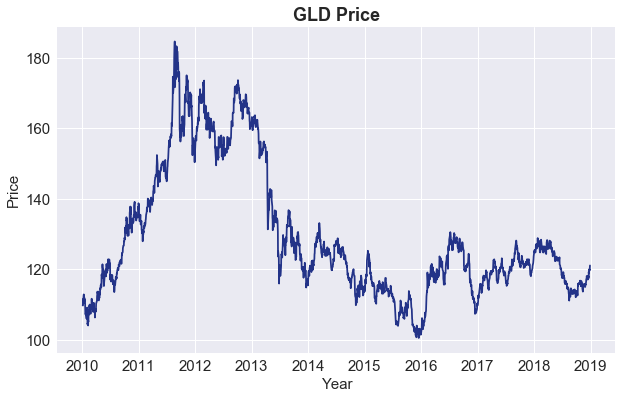

count    2263.000000
mean      129.275789
std        18.569088
min       100.500000
25%       116.485001
50%       122.849998
75%       136.504997
max       184.589996
Name: price, dtype: float64

In [4]:
plt.figure(figsize=(10,6))
plt.plot(data.price, color='#233388')
plt.title('GLD Price',fontsize=18,fontweight="bold")
plt.xlabel('Year',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show();

data.price.describe()

After analyzing the GLD price evolution, we create an histogram of the daily log returns. It seems that the behaviour of the returns is not normal due to the fat tails (extreme observations) and the leptokurtic shape (concentration of returns around the mean).

/Users/mateo/miniconda3/envs/workingEnv/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mateo/miniconda3/envs/workingEnv/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


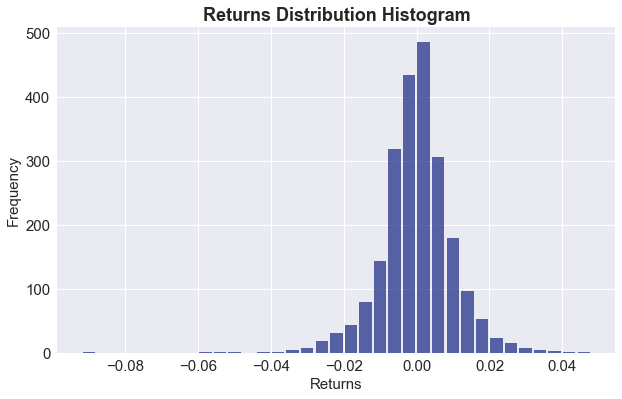

In [5]:
plt.figure(figsize=[10,6])
plt.hist(x=data['returns'], bins=35, color='#233388',alpha=0.75, rwidth=0.85)
plt.xlabel('Returns',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Returns Distribution Histogram',fontsize=18,fontweight="bold")
plt.show();

## Calculating SMAs

To implement an SMA strategy we need to calculate 2 rolling means, one that represent the short term movements and another one for long term. With python we can rapidly calculate them with the *.rolling().mean()* functions.

As an example, the theoretical formula for the 252 SMA is:

$$SMA_{252} = \frac{r_{1} + r_{2}  + ... + r_{252} }{252}$$


In [6]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()

In [7]:
data.tail()

,price,returns,SMA1,SMA2
Date,,,,
2018-12-21,118.720001,-0.004370,116.329524,120.213095
2018-12-24,120.019997,0.010891,116.415952,120.211945
2018-12-26,119.660004,-0.003004,116.487381,120.206865
2018-12-27,120.570000,0.007576,116.586666,120.202103
2018-12-28,121.059998,0.004056,116.688809,120.197461


We represent graphically the SMAs that we calculated previously. As we can see, the short term mean (SMA1) is more volatile than the long term mean (SMA2). Acording to some technical analysts, when the SMA1 crosses above the SMA2 is a bullish signal that indicates a change in trend. This is also known as the golden cross.

>The golden cross is a candlestick pattern that is a bullish signal in which a relatively short-term moving average crosses above a long-term moving average. The golden cross is a bullish breakout pattern formed from a crossover involving a security's short-term moving average (such as the 15-day moving average) breaking above its long-term moving average (such as the 50-day moving average) or resistance level. As long-term indicators carry more weight, the golden cross indicates a bull market on the horizon and is reinforced by high trading volumes.

Source: https://www.investopedia.com/terms/g/goldencross.asp


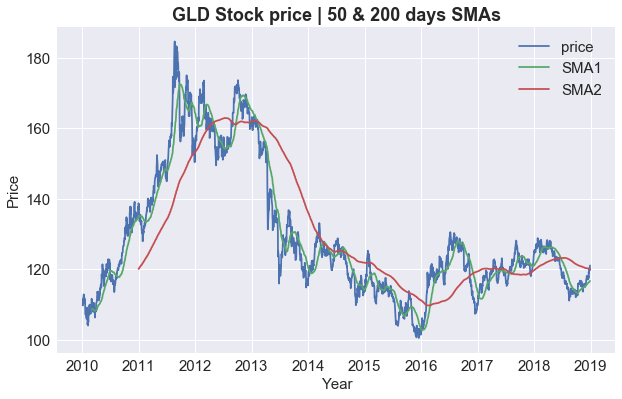

In [8]:
plt.figure(figsize=(10,6))
plt.plot(data['price'], label='price')
plt.plot(data['SMA1'], label='SMA1')
plt.plot(data['SMA2'], label='SMA2')
plt.title('{} Stock price | 50 & 200 days SMAs'.format(ticker),fontsize=18,fontweight="bold")
plt.xlabel('Year',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc=0,fontsize=15)
plt.show();

## Creating the Strategy

Once we have the SMAs variables, we can proceed to create the strategy. Following the theory mencioned before, we will create a long signal when $ SMA_{1} > SMA_{2} $ and a short signal when $ SMA_{2} >= SMA_{1} $. The long / short signals will be 1 and -1 respectively.

In [9]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

With the signals we can calculate the return of the strategy by multiplying the signals of the previous period by the return of the actual return of that period.

$$ return_{strategy \: t} = signal_{t-1} \times return_{stock \: t} $$

In [10]:
data['strategy'] = data['position'].shift(1) * data['returns']

In [11]:
data = data.dropna()
data.head()

,price,returns,SMA1,SMA2,position,strategy
Date,,,,,,
2010-12-31,138.720001,0.012258,135.028810,120.069762,1,-0.012258
2011-01-03,138.000000,-0.005204,135.160000,120.181667,1,-0.005204
2011-01-04,134.750000,-0.023832,135.235715,120.281072,1,-0.023832
2011-01-05,134.369995,-0.002824,135.196191,120.371786,1,-0.002824
2011-01-06,133.830002,-0.004027,135.135476,120.463095,1,-0.004027


Given that we are working with logarighmic returns, we sum them to check the overall return of the GLD vs the strategy and then apply the exponential function to calculate the gross returns.  

In [12]:
np.exp(data[['returns', 'strategy']].sum())

returns     0.883456
strategy    1.081087
dtype: float64

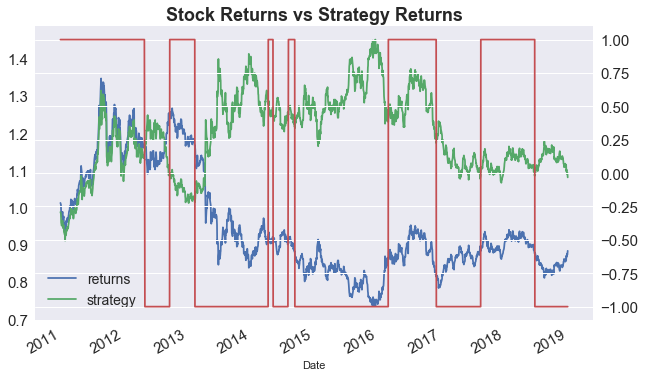

In [13]:
ax = data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=(10, 6),fontsize=15)
ax.set_title('Stock Returns vs Strategy Returns',fontsize=18,fontweight="bold")
data['position'].plot(ax=ax, secondary_y='position',fontsize=15)
ax.grid(False)
ax.legend(loc='lower left',fontsize=14);



Given that is easier to work and interpret yearly measures, we proceed to calculate the yearly net returns and standard deviation. To conclude, we can see that the strategy did not provide almost any value but the return of the GLD was even worst (negativa). On the volatility side, we can see that the annualized standard deviation is almost the same for the strategy and for the GLD ETF.

In [14]:
np.exp(data[['returns', 'strategy']].mean() * 252) - 1

returns    -0.015400
strategy    0.009813
dtype: float64

In [15]:
data[['returns', 'strategy']].std() * 252 ** 0.5

returns     0.158191
strategy    0.158193
dtype: float64

<img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" align="right" border="0" width="35%" >